# EDA CsCi708 Fall 2020 

Research Objective: 

    To analyze and determine an optimal range of outdoor mobility during the Covid-19 pandemic to reduce the infection and death counts in a particular county.

Motivation:

    I'm interested in predicting infection and also predicting death due to COVID-19 modeled by the effect of outdoor mobility and air quality indicators (Air quiality index, CO, SO2, NO2, Ozone)

Method: 

    -Exploratory data analysis and regression analysis to understand the effects of air quality rates, mobility data in local parks, and the JHU Covid-19 infection data
    
    -If there are reasonable findings from the EDA, form an optimization problem to determine optimal range of outdoor pedestrian mobility. As far as scope, I would be focusing on time series data for a few counties within range of January 2020 - May 2020 due to dataset restrictions
    
    -Validation: first by using previous months to predict future months and comparing fitted model to predictive model. Another interesting way would be to cluster counties based on census attributes and validate via the results of counties within the same clusters (or use MIP matching optimization problem to match counties with the most similar characteristics via census factors); I would need many counties for this and it may not be appropriate

Sources:
    
    MOBILITY DATA - Google
    Global: https://www.google.com/covid19/mobility/

    
    AIR QUALITY DATA - EPA
    Separate files for CO, NO2, S02, Ozone, and Air Quality Index (AIQ)
    https://aqs.epa.gov/aqsweb/airdata/download_files.html
    January 2020 - May 2020
    
    another option:
    https://www.airnow.gov/?city=Washington&state=DC&country=USA
    https://aqs.epa.gov/aqsweb/documents/data_api.html
    user id: dmheymann@email.wm.edu
    key: refer to email
    
    CENSUS
    still need to decide which file to use; will be necessary later in validation phase
    
    COVID-19 - JHU
    https://github.com/CSSEGISandData/COVID-19
    Dr. GuanNan Wang's files
    
    

In [2]:
#initial statements for numpy and pandas packages
import math
import numpy as np
import pandas as pd
import csv
import os
import datetime
import seaborn as sns
import scipy as sp
from scipy.special import boxcox1p
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import matplotlib as mpl 
from mpl_toolkits.mplot3d import Axes3D 
import statsmodels.graphics.api as smg
import random
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import requests
import json


In [3]:
path= "C:/Users/dheym/OneDrive/Documents/GitHub/csci708/src"
#set directory
os.chdir('src/')
os.getcwd()

'C:\\Users\\dheym\\OneDrive\\Documents\\GitHub\\csci708\\src'

# Import national datasets (mobility, JHU COVID-19, Census)

In [163]:
#import src files
#google mobility global report
mobility_dat = pd.read_csv('Global_Mobility_Report.csv')

C:\Users\dheym\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [164]:
#print(mobility_dat.country_region.unique())
US_mobility = mobility_dat[mobility_dat.country_region == 'United States']
CA_mobility = US_mobility[US_mobility.sub_region_1 == 'California']
CA_mobility.dropna()
SantaBarbara_mobility = CA_mobility[CA_mobility.sub_region_2 == 'Santa Barbara County']
Ventura_mobility = CA_mobility[CA_mobility.sub_region_2 == 'Ventura County']
Sacramento_mobility = CA_mobility[CA_mobility.sub_region_2 == 'Sacramento County']

#min and max dates
print("Sacremento", "\n", "date range: [", Sacramento_mobility.date.min(), ", ", Sacramento_mobility.date.max(), "]")
print("Ventura", "\n", "date range: [", Ventura_mobility.date.min(), ", ", Ventura_mobility.date.max(), "]")
print("Santa Barbara", "\n", "date range: [", SantaBarbara_mobility.date.min(), ", ", SantaBarbara_mobility.date.max(), "]")

Sacremento 
 date range: [ 2020-02-15 ,  2020-08-17 ]
Ventura 
 date range: [ 2020-02-15 ,  2020-08-17 ]
Santa Barbara 
 date range: [ 2020-02-15 ,  2020-08-17 ]


In [165]:
Ventura_mobility.columns
Ventura_mobility_simple = Ventura_mobility[["date", "parks_percent_change_from_baseline"]]
SantaBarbara_mobility_simple = SantaBarbara_mobility[["date", "parks_percent_change_from_baseline"]]
Sacramento_mobility_simple = Sacramento_mobility[["date", "parks_percent_change_from_baseline"]]

In [166]:
#JHU Data import
JHU_county_D = pd.read_csv('JHU_Cum_Death_county_2020-08-26_updated.tsv', sep='\t') 
JHU_county_I = pd.read_csv('JHU_Cum_Infected_county_2020-08-26_updated.tsv', sep='\t') 
JHU_state_D = pd.read_csv('JHU_Cum_Death_state_2020-08-26_updated.tsv', sep='\t') 
JHU_state_I = pd.read_csv('JHU_Cum_Infection_state_2020-08-26_updated.tsv', sep='\t') 

JHU_county_D.sample(5)

#get row of county of interest and turn into date time series


,ID,County,State,X2020.01.22,X2020.01.23,X2020.01.24,X2020.01.25,X2020.01.26,X2020.01.27,X2020.01.28,...,X2020.08.16,X2020.08.17,X2020.08.18,X2020.08.19,X2020.08.20,X2020.08.21,X2020.08.22,X2020.08.23,X2020.08.24,X2020.08.25
2307,44009,Washington,RhodeIsland,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3100,55123,Vernon,Wisconsin,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2490,47143,Rhea,Tennessee,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
786,19011,Benton,Iowa,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2100,39131,Pike,Ohio,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [167]:
#dataframe containing cumulative death and infection counts for specified county and state combo

county = "Ventura"
state = "California"
county_row_index = JHU_county_D[(JHU_county_D.County == county) & (JHU_county_D.State == state)].index.values.astype(int)[0]
# JHU_<county name>_D_a is the list containing cum death count
JHU_Ventura_D_a = JHU_county_D.loc[county_row_index, :].values.tolist()
del JHU_Ventura_D_a[0:3]
JHU_Ventura_D_a.reverse()
JHU_Ventura_I_a = JHU_county_I.loc[county_row_index, :].values.tolist()
del JHU_Ventura_I_a[0:3]
JHU_Ventura_I_a.reverse()

dates = pd.date_range(start='2020-01-22', end='2020-08-25')
JHU_Ventura_df = pd.DataFrame()
JHU_Ventura_df['Date'] = dates
#need to reverse the data because the tsv file imported was meant to be reversed
JHU_Ventura_df['Death'] = JHU_Ventura_D_a
#need to reverse the data because the tsv file imported was meant to be reversed
JHU_Ventura_df['Infected'] = JHU_Ventura_I_a
JHU_Ventura_df['I_diff'] = (JHU_Ventura_df['Infected']-JHU_Ventura_df['Infected'].shift()).fillna(0)
JHU_Ventura_df['D_diff'] = (JHU_Ventura_df['Death']-JHU_Ventura_df['Death'].shift()).fillna(0)
JHU_Ventura_df.sample(2)



,Date,Death,Infected,I_diff,D_diff
203,2020-08-12,93,8740,0.0,0.0
205,2020-08-14,95,9090,300.0,2.0


In [168]:
#dataframe containing cumulative death and infection counts for specified county and state combo

county = "SantaBarbara"
state = "California"
county_row_index = JHU_county_D[(JHU_county_D.County == county) & (JHU_county_D.State == state)].index.values.astype(int)[0]
# JHU_<county name>_D_a is the list containing cum death count
JHU_SantaBarbara_D_a = JHU_county_D.loc[county_row_index, :].values.tolist()
del JHU_SantaBarbara_D_a[0:3]
JHU_SantaBarbara_D_a.reverse()
JHU_SantaBarbara_I_a = JHU_county_I.loc[county_row_index, :].values.tolist()
del JHU_SantaBarbara_I_a[0:3]
JHU_SantaBarbara_I_a.reverse()

dates = pd.date_range(start='2020-01-22', end='2020-08-25')
JHU_SantaBarbara_df = pd.DataFrame()
JHU_SantaBarbara_df['Date'] = dates
#need to reverse the data because the tsv file imported was meant to be reversed
JHU_SantaBarbara_df['Death'] = JHU_SantaBarbara_D_a
#need to reverse the data because the tsv file imported was meant to be reversed
JHU_SantaBarbara_df ['Infected'] = JHU_SantaBarbara_I_a
JHU_SantaBarbara_df['I_diff'] = (JHU_SantaBarbara_df['Infected']-JHU_SantaBarbara_df['Infected'].shift()).fillna(0)
JHU_SantaBarbara_df['D_diff'] = (JHU_SantaBarbara_df['Death']-JHU_SantaBarbara_df['Death'].shift()).fillna(0)

JHU_SantaBarbara_df.sample(2)
#data cleaning to fix the 28 deaths bundle
#JHU_SantaBarbara_df.to_csv (r'C:\Users\dheym\OneDrive\Documents\GitHub\csci708\src\problemSB_JHU.csv', index = None, header=True) 
JHU_SantaBarbara_df = pd.read_csv('JHU_SB_good.csv')

In [169]:
#dataframe containing cumulative death and infection counts for specified county and state combo

county = "Sacramento"
state = "California"
county_row_index = JHU_county_D[(JHU_county_D.County == county) & (JHU_county_D.State == state)].index.values.astype(int)[0]
# JHU_<county name>_D_a is the list containing cum death count
JHU_Sacramento_D_a = JHU_county_D.loc[county_row_index, :].values.tolist()
del JHU_Sacramento_D_a[0:3]
JHU_Sacramento_D_a.reverse()
JHU_Sacramento_I_a = JHU_county_I.loc[county_row_index, :].values.tolist()
del JHU_Sacramento_I_a[0:3]
JHU_Sacramento_I_a.reverse()

dates = pd.date_range(start='2020-01-22', end='2020-08-25')
JHU_Sacramento_df = pd.DataFrame()
JHU_Sacramento_df['Date'] = dates
#need to reverse the data because the tsv file imported was meant to be reversed
JHU_Sacramento_df['Death'] = JHU_Sacramento_D_a
#need to reverse the data because the tsv file imported was meant to be reversed
JHU_Sacramento_df ['Infected'] = JHU_Sacramento_I_a
JHU_Sacramento_df['I_diff'] = (JHU_Sacramento_df['Infected']-JHU_Sacramento_df['Infected'].shift()).fillna(0)
JHU_Sacramento_df['D_diff'] = (JHU_Sacramento_df['Death']-JHU_Sacramento_df['Death'].shift()).fillna(0)


JHU_Sacramento_df.sample(2)

,Date,Death,Infected,I_diff,D_diff
211,2020-08-20,230,14764,4.0,0.0
33,2020-02-24,0,1,0.0,0.0


# Import Air Quality Data

counties of interest: 
- **Sacramento County, CA** FIPS code: 06067 <br>
- **Santa Barbara County, CA** FIPS code: 06083 <br>
- **Ventura County, CA** FIPS code: 06111 <br>

California was one of the first US states to have COVID-19 cases. These major cities should have higher validity in infection counts due to early wave of COVID-19 <br>

Due to vast differences in each state and county in terms of policies and mandates, it is necessary to produce a model for each specific area of region to allow for a clear analysis.


In [11]:
my_counties = [ "Santa Barbara", "Sacramento", "Ventura"]
#daily_aqi.head(5)

In [170]:
#Import files for annual and daily AQI, daily: CO, NO2, SO2, Ozone
annual_aqi = pd.read_csv('annual_aqi_by_county_2020.csv')
daily_aqi = pd.read_csv('daily_aqi_by_county_2020.csv')
daily_CO = pd.read_csv('daily_CO_42101_2020.csv')
daily_NO2 = pd.read_csv('daily_NO2_42602_2020.csv')
daily_Ozone = pd.read_csv('daily_Ozone_44201_2020.csv')
daily_SO2 = pd.read_csv('daily_SO2_42401_2020.csv')
daily_PM10_CA = pd.read_csv('daily_PM10_81102_2020.csv')
daily_PM2_5_CA = pd.read_csv('daily_PM2.5_88101_2020.csv')

In [171]:
annual_aqi.head(5)
annual_aqi_CA = annual_aqi[annual_aqi.State == "California"]
#annual_aqi_LA = annual_aqi[(annual_aqi.State == "California") & (annual_aqi.County == "Los Angeles")]
annual_aqi_CA.head(5)
annual_aqi_CA.County.unique()


array(['Butte', 'Colusa', 'Fresno', 'Imperial', 'Inyo', 'Kern', 'Kings',
       'Madera', 'Mariposa', 'Merced', 'Nevada', 'Placer', 'Plumas',
       'Riverside', 'Sacramento', 'San Benito', 'San Bernardino',
       'San Diego', 'San Luis Obispo', 'Santa Barbara', 'Shasta',
       'Stanislaus', 'Sutter', 'Tulare', 'Ventura', 'Yolo'], dtype=object)

In [14]:
daily_aqi.head(5)
daily_aqi.rename(columns = {'State Name':'State'}, inplace = True) 
daily_aqi.rename(columns = {'county Name':'County'}, inplace = True) 
daily_aqi_CA = daily_aqi[daily_aqi.State == "California"]
daily_aqi_CA.head(5)
daily_aqi_CA.County.unique()

array(['Butte', 'Colusa', 'Fresno', 'Imperial', 'Inyo', 'Kern', 'Kings',
       'Madera', 'Mariposa', 'Merced', 'Nevada', 'Placer', 'Plumas',
       'Riverside', 'Sacramento', 'San Benito', 'San Bernardino',
       'San Diego', 'San Luis Obispo', 'Santa Barbara', 'Shasta',
       'Stanislaus', 'Sutter', 'Tulare', 'Ventura', 'Yolo'], dtype=object)

In [172]:
daily_CO.rename(columns = {'State Name':'State'}, inplace = True) 
daily_CO.rename(columns = {'County Name':'County'}, inplace = True) 
daily_CO.head(5)
daily_CO_CA = daily_CO[daily_CO.State == "California"]
print(daily_CO_CA.County.unique())
daily_CO_CA.rename(columns = {'State':'state', "Date Local": "date_local", 
                               "County": "county", "Site Num": "site_number", "AQI" : "aqi", 
                               "Parameter Code" : "parameter_code", "Parameter Name" : "parameter",
                               "Sample Duration" : "sample_duration","Units of Measure" : "units_of_measure", 
                               "Event Type" : "event_type","Observation Count" : "observation_count", 
                               "Observation Percent" : "observation_percent", "Arithmetic Mean": "arithmetic_mean"
                              }, inplace = True) 
print(daily_CO_CA.columns)
SantaBarbara_CA_42101_a = daily_CO_CA[daily_CO_CA.county == "Santa Barbara"]
SantaBarbara_CA_42101_1 = SantaBarbara_CA_42101_a[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
SantaBarbara_CA_42101_1.sample(2)

['Santa Barbara']
Index(['State Code', 'County Code', 'site_number', 'parameter_code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'parameter', 'sample_duration',
       'Pollutant Standard', 'date_local', 'units_of_measure', 'event_type',
       'observation_count', 'observation_percent', 'arithmetic_mean',
       '1st Max Value', '1st Max Hour', 'aqi', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'state', 'county', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')


C:\Users\dheym\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,state,date_local,county,site_number,aqi,parameter_code,parameter,sample_duration,units_of_measure,event_type,observation_count,observation_percent,arithmetic_mean
1041,California,2020-02-20,Santa Barbara,1025,2.0,42101,Carbon monoxide,8-HR RUN AVG END HOUR,Parts per million,Included,24,100.0,0.200000
1001,California,2020-02-27,Santa Barbara,1025,NaN,42101,Carbon monoxide,1 HOUR,Parts per million,Included,23,96.0,0.156522


In [173]:
daily_NO2.head(5)
daily_NO2.rename(columns = {'State Name':'State'}, inplace = True) 
daily_NO2.rename(columns = {'County Name':'County'}, inplace = True) 
daily_NO2_CA = daily_NO2[daily_NO2.State == "California"]
daily_NO2_CA.rename(columns = {'State':'state', "Date Local": "date_local", 
                               "County": "county", "Site Num": "site_number", "AQI" : "aqi", 
                               "Parameter Code" : "parameter_code", "Parameter Name" : "parameter",
                               "Sample Duration" : "sample_duration","Units of Measure" : "units_of_measure", 
                               "Event Type" : "event_type","Observation Count" : "observation_count", 
                               "Observation Percent" : "observation_percent", "Arithmetic Mean": "arithmetic_mean"
                              }, inplace = True) 
print(daily_NO2_CA.columns)
Ventura_CA_42602_a = daily_NO2_CA[daily_NO2_CA.county == "Ventura"]
Ventura_CA_42602_1 = Ventura_CA_42602_a[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
SantaBarbara_CA_42602_a = daily_NO2_CA[daily_NO2_CA.county == "Santa Barbara"]
SantaBarbara_CA_42602_1 = SantaBarbara_CA_42602_a[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
Sacramento_CA_42602_a = daily_NO2_CA[daily_NO2_CA.county == "Sacramento"]
Sacramento_CA_42602_1 = Sacramento_CA_42602_a[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
#"Date Local", "County", "State", "Site Num", "AQI", "Parameter Code", "Parameter Name", "Sample Duration", 
#"Units of Measure", "Event Type","Observation Count", "Observation Percent", "Arithmetic Mean"
daily_NO2_CA.county.unique()

Index(['State Code', 'County Code', 'site_number', 'parameter_code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'parameter', 'sample_duration',
       'Pollutant Standard', 'date_local', 'units_of_measure', 'event_type',
       'observation_count', 'observation_percent', 'arithmetic_mean',
       '1st Max Value', '1st Max Hour', 'aqi', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'state', 'county', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')


C:\Users\dheym\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


array(['Riverside', 'San Luis Obispo', 'Santa Barbara', 'Ventura'],
      dtype=object)

In [174]:
daily_Ozone.head(5)
daily_Ozone.rename(columns = {'State Name':'State'}, inplace = True) 
daily_Ozone.rename(columns = {'County Name':'County'}, inplace = True) 
#print(daily_Ozone.head(5))
daily_Ozone_CA = daily_Ozone[daily_Ozone.State == "California"]
print(daily_Ozone_CA.County.unique())

daily_Ozone_CA.rename(columns = {'State':'state', "Date Local": "date_local", 
                               "County": "county", "Site Num": "site_number", "AQI" : "aqi", 
                               "Parameter Code" : "parameter_code", "Parameter Name" : "parameter",
                               "Sample Duration" : "sample_duration","Units of Measure" : "units_of_measure", 
                               "Event Type" : "event_type","Observation Count" : "observation_count", 
                               "Observation Percent" : "observation_percent", "Arithmetic Mean": "arithmetic_mean"
                              }, inplace = True) 
print(daily_Ozone_CA.columns)
SantaBarbara_CA_44201_a = daily_Ozone_CA[daily_Ozone_CA.county == "Santa Barbara"]
SantaBarbara_CA_44201_1 = SantaBarbara_CA_44201_a[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
SantaBarbara_CA_44201_1

Ventura_CA_44201_a = daily_Ozone_CA[daily_Ozone_CA.county == "Ventura"]
Ventura_CA_44201_1 = Ventura_CA_44201_a[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
Ventura_CA_44201_1.sample(2)


['Fresno' 'Inyo' 'Kings' 'Mariposa' 'Nevada' 'Riverside' 'San Benito'
 'San Bernardino' 'San Diego' 'San Luis Obispo' 'Santa Barbara' 'Shasta'
 'Tulare' 'Ventura']
Index(['State Code', 'County Code', 'site_number', 'parameter_code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'parameter', 'sample_duration',
       'Pollutant Standard', 'date_local', 'units_of_measure', 'event_type',
       'observation_count', 'observation_percent', 'arithmetic_mean',
       '1st Max Value', '1st Max Hour', 'aqi', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'state', 'county', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')


C:\Users\dheym\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,state,date_local,county,site_number,aqi,parameter_code,parameter,sample_duration,units_of_measure,event_type,observation_count,observation_percent,arithmetic_mean
3768,California,2020-03-30,Ventura,3001,36,44201,Ozone,8-HR RUN AVG BEGIN HOUR,Parts per million,None,17,100.0,0.026000
3565,California,2020-03-04,Ventura,1004,40,44201,Ozone,8-HR RUN AVG BEGIN HOUR,Parts per million,None,17,100.0,0.025765


In [175]:
daily_SO2.head(5)
daily_SO2.rename(columns = {'State Name':'State'}, inplace = True) 
daily_SO2.rename(columns = {'County Name':'County'}, inplace = True) 
#print(daily_SO2.head(5))
daily_SO2_CA = daily_SO2[daily_SO2.State == "California"]
daily_SO2_CA.County.unique()

daily_SO2_CA.rename(columns = {'State':'state', "Date Local": "date_local", 
                               "County": "county", "Site Num": "site_number", "AQI" : "aqi", 
                               "Parameter Code" : "parameter_code", "Parameter Name" : "parameter",
                               "Sample Duration" : "sample_duration","Units of Measure" : "units_of_measure", 
                               "Event Type" : "event_type","Observation Count" : "observation_count", 
                               "Observation Percent" : "observation_percent", "Arithmetic Mean": "arithmetic_mean"
                              }, inplace = True) 
print(daily_SO2_CA.columns)
SantaBarbara_CA_42401_a = daily_SO2_CA[daily_SO2_CA.county == "Santa Barbara"]
SantaBarbara_CA_42401_1 = SantaBarbara_CA_42401_a[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
SantaBarbara_CA_42401_1.sample(2)

Index(['State Code', 'County Code', 'site_number', 'parameter_code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'parameter', 'sample_duration',
       'Pollutant Standard', 'date_local', 'units_of_measure', 'event_type',
       'observation_count', 'observation_percent', 'arithmetic_mean',
       '1st Max Value', '1st Max Hour', 'aqi', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'state', 'county', 'City Name',
       'CBSA Name', 'Date of Last Change'],
      dtype='object')


C:\Users\dheym\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,state,date_local,county,site_number,aqi,parameter_code,parameter,sample_duration,units_of_measure,event_type,observation_count,observation_percent,arithmetic_mean
1338,California,2020-02-26,Santa Barbara,1025,0.0,42401,Sulfur dioxide,1 HOUR,Parts per billion,Included,23,96.0,0.0
1366,California,2020-01-25,Santa Barbara,1025,NaN,42401,Sulfur dioxide,3-HR BLK AVG,Parts per billion,Included,7,88.0,0.0


# More data for air quality using the API

In [ ]:
#This data is retrieved via querying the API of the EPA AQS system
#This will add more data to follow the data that EPA has published in CSV form
#This data extends until the current day
#https://aqs.epa.gov/aqsweb/documents/data_api.html#daily

#First query for getting Ventura County, CA (FIP: 06 111) for Ozone (param 44201); begin date: May 1, 2020; end date: July 8
#https://aqs.epa.gov/data/api/dailyData/byCounty?email=dmheymann@email.wm.edu&key=<enterkeyhere>&param=44201&bdate=20200501&edate=20200708&state=06&county=111 

#this is what one entry looks like
'''{
      "state_code": "06",
      "county_code": "111",
      "site_number": "0007",
      "parameter_code": "44201",
      "poc": 1,
      "latitude": 34.210169,
      "longitude": -118.870509,
      "datum": "NAD83",
      "parameter": "Ozone",
      "sample_duration": "8-HR RUN AVG BEGIN HOUR",
      "pollutant_standard": "Ozone 8-hour 2015",
      "date_local": "2020-06-30",
      "units_of_measure": "Parts per million",
      "event_type": "None",
      "observation_count": 12,
      "observation_percent": 71.0,
      "validity_indicator": "N",
      "arithmetic_mean": 0.0325,
      "first_max_value": 0.038,
      "first_max_hour": 8,
      "aqi": 35,
      "method_code": "087",
      "method": "INSTRUMENTAL - ULTRA VIOLET ABSORPTION",
      "local_site_name": "Thousand Oaks",
      "site_address": "2323 Moorpark Road, Thousand Oaks, CA  91360",
      "state": "California",
      "county": "Ventura",
      "city": "Thousand Oaks",
      "cbsa_code": "37100",
      "cbsa": "Oxnard-Thousand Oaks-Ventura, CA",
      "date_of_last_change": "2020-08-14"
    }'''

In [ ]:
#DONT RUN, JUST FOR REFERENCE
county_state_pollutant_1 = "Ventura_CA_Ozone"
#enter key in the <enterkeyhere> before running
response_1 = requests.get('https://aqs.epa.gov/data/api/dailyData/byCounty?email=dmheymann@email.wm.edu&key=<enterkeyhere>&param=44201&bdate=20200501&edate=20200708&state=06&county=111')
#print(response)
if response_1.status_code == 200:
    json_1 = json.loads(response_1.content.decode('utf-8'))
json_dat_1 = json_1["Data"]
data_df_1 = pd.DataFrame(json_dat_1)
data_df_1.to_csv(path + "/" + county_state_pollutant + ".csv")    
data_df_1

In [ ]:
# pollutant codes:
'''
      "code": "14129",
      "value_represented": "Lead (TSP) LC"
    },
    {
      "code": "42101",
      "value_represented": "Carbon monoxide"
    },
    {
      "code": "42401",
      "value_represented": "Sulfur dioxide"
    },
    {
      "code": "42602",
      "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
      "code": "44201",
      "value_represented": "Ozone"
    },
    {
      "code": "81102",
      "value_represented": "PM10 Total 0-10um STP"
    },
    {
      "code": "85129",
      "value_represented": "Lead PM10 LC FRM/FEM"
    },
    {
      "code": "88101",
      "value_represented": "PM2.5 - Local Conditions"
    }


What I will use:
"code": "42101",
      "value_represented": "Carbon monoxide"
"code": "42401",
      "value_represented": "Sulfur dioxide"
"code": "42602",
      "value_represented": "Nitrogen dioxide (NO2)"
"code": "44201",
      "value_represented": "Ozone"
"code": "81102",
      "value_represented": "PM10 Total 0-10um STP"
"code": "85129",
      "value_represented": "Lead PM10 LC FRM/FEM"
"code": "88101",
      "value_represented": "PM2.5 - Local Conditions"
      
      '''

In [19]:
def EPA_API_get_data(state_code, county_code, pollutant_code):


    #Query #2 for getting Ventura County, CA (FIP: 06 111) for Ozone (param 44201); begin date: May 1, 2020; end date: July 8
    #https://aqs.epa.gov/data/api/dailyData/byCounty?email=dmheymann@email.wm.edu&key=<enterkeyhere>&param=44201&bdate=20200501&edate=20200708&state=06&county=111 
    county_state_pollutant = county_code + "_" + state_code + "_" + pollutant_code
    
    #Dates:: [May 5 2020, July 8 2020]
    #response = requests.get('https://aqs.epa.gov/data/api/dailyData/byCounty?email=dmheymann@email.wm.edu&key=<enterkeyhere>&param=' + pollutant_code + '&bdate=20200501&edate=20200708&state=' + state_code + '&county=' + county_code)
    
    #Dates:: [Jan 1 2020, July 8 2020]
    response = requests.get('https://aqs.epa.gov/data/api/dailyData/byCounty?email=dmheymann@email.wm.edu&key=<enterkeyhere>&param=' + pollutant_code + '&bdate=20200101&edate=20200708&state=' + state_code + '&county=' + county_code)
    
    #print(response)
    if response.status_code == 200:
        my_json = json.loads(response.content.decode('utf-8'))
    json_dat = my_json["Data"]
    data_df = pd.DataFrame(json_dat)
    data_df.to_csv(path + "/" + county_state_pollutant + "_i.csv")    
    data_df

In [331]:
pollutants = ["42101", "42401", "42602", "44201", "81102", "85129", "88101"]
pollutants_pb = ["81102", "88101"]
pollutants_set3 = ["44201", "42602"]
pollutants_set4 = ["42101", "42602", "42401", "44201"]

**NOTE: only run once- <br> Once the .csv file has been created for a county_state_pollutant, no need to recreate and flood the API with queries**

In [21]:
#state, county, pollutant codes


#california state code
state_code_CA = "06"
#Ventura county code
county_Ventura = "111"

for i in range(len(pollutants_pb)):
    EPA_API_get_data(state_code_CA, county_Ventura, pollutants_pb[i])


In [330]:
#Sacramento county code
county_Sacramento = "067"

for i in range(len(pollutants_set3)):
    EPA_API_get_data(state_code_CA, county_Sacramento, pollutants_set3[i])


In [332]:
#Santa Barbara county code
state_code_CA = "06"
county_SantaBarbara = "083"

for i in range(len(pollutants_set4)):
    EPA_API_get_data(state_code_CA, county_SantaBarbara, pollutants_set4[i])


**NOTE: start running from here again to import the csv files that were already created at some point prior**

In [176]:
#Import csv files for county_state_pollutant selections (California)

#state_code_CA = "06"
#pollutants = ["42101", "42401", "42602", "44201", "81102", "85129", "88101"]

#county_Ventura = "111"
Ventura_CA_42101 = pd.read_csv("111_06_42101.csv")
Ventura_CA_42401 = pd.read_csv("111_06_42401.csv")
Ventura_CA_42602 = pd.read_csv("111_06_42602.csv")
Ventura_CA_44201 = pd.read_csv("111_06_44201.csv")
Ventura_CA_81102 = pd.read_csv("111_06_81102.csv")
Ventura_CA_85129 = pd.read_csv("111_06_85129.csv")
Ventura_CA_88101 = pd.read_csv("111_06_88101.csv")

#county_Sacramento = "067"
Sacramento_CA_42101 = pd.read_csv("067_06_42101.csv")
Sacramento_CA_42401 = pd.read_csv("067_06_42401.csv")
Sacramento_CA_42602 = pd.read_csv("067_06_42602_i.csv")
Sacramento_CA_44201 = pd.read_csv("067_06_44201_i.csv")
Sacramento_CA_81102 = pd.read_csv("067_06_81102.csv")
Sacramento_CA_85129 = pd.read_csv("067_06_85129.csv")
Sacramento_CA_88101 = pd.read_csv("067_06_88101.csv")

#county_SantaBarbara = "085"
SantaBarbara_CA_42101 = pd.read_csv("083_06_42101_i.csv")
SantaBarbara_CA_42401 = pd.read_csv("083_06_42401_i.csv")
SantaBarbara_CA_42602 = pd.read_csv("083_06_42602_i.csv")
SantaBarbara_CA_44201 = pd.read_csv("083_06_44201_i.csv")
SantaBarbara_CA_81102 = pd.read_csv("083_06_81102.csv")
SantaBarbara_CA_85129 = pd.read_csv("083_06_85129.csv")
SantaBarbara_CA_88101 = pd.read_csv("083_06_88101.csv")


In [177]:
#Let's take a look at these dataframe

list_of_CA_dfs = [
Ventura_CA_42101,
Ventura_CA_42401,
Ventura_CA_42602,
Ventura_CA_44201,
Ventura_CA_81102,
Ventura_CA_85129,
Ventura_CA_88101,
Sacramento_CA_42101,
Sacramento_CA_42401,
Sacramento_CA_42602,
Sacramento_CA_44201,
Sacramento_CA_81102,
Sacramento_CA_85129,
Sacramento_CA_88101,
SantaBarbara_CA_42101,
SantaBarbara_CA_42401,
SantaBarbara_CA_42602,
SantaBarbara_CA_44201,
SantaBarbara_CA_81102,
SantaBarbara_CA_85129,
SantaBarbara_CA_88101]

not_null_CA = []
for j in range(len(list_of_CA_dfs)):
    the_df = list_of_CA_dfs[j]
    #print("\n", "element number: ",j, "\n", "first 5: ", "\n", the_df.head(), "\n", "info: ", the_df.info()) 
    
    #keep track of dataframes that aren't empty
    if the_df.empty == False:
        print("\n", "element number: ",j)
        not_null_CA.append(the_df)


 element number:  2

 element number:  3

 element number:  4

 element number:  6

 element number:  9

 element number:  10

 element number:  11

 element number:  13

 element number:  14

 element number:  15

 element number:  16

 element number:  17

 element number:  18

 element number:  20


In [22]:
len(not_null_CA)
'''

0 Ventura_CA_42101,
1 Ventura_CA_42401,
2_ Ventura_CA_42602, *
3_ Ventura_CA_44201, *
4_ Ventura_CA_81102, *
5 Ventura_CA_85129,
6_ Ventura_CA_88101,*
7 Sacramento_CA_42101,
8 Sacramento_CA_42401,
9_ Sacramento_CA_42602,****API get
10_ Sacramento_CA_44201,*****API get
11_ Sacramento_CA_81102,*
12 Sacramento_CA_85129,
13_ Sacramento_CA_88101,*
14_ SantaBarbara_CA_42101,*
15_ SantaBarbara_CA_42401,*
16_ SantaBarbara_CA_42602,*
17_ SantaBarbara_CA_44201,*
18_ SantaBarbara_CA_81102,*
19 SantaBarbara_CA_85129,
20_ SantaBarbara_CA_88101 *


"code": "42101",
      "value_represented": "Carbon monoxide"
      
"code": "42401",
      "value_represented": "Sulfur dioxide"
      
"code": "42602",
      "value_represented": "Nitrogen dioxide (NO2)"
      
"code": "44201",
      "value_represented": "Ozone"
      
"code": "81102",
      "value_represented": "PM10 Total 0-10um STP"
      
"code": "85129",
      "value_represented": "Lead PM10 LC FRM/FEM"
      
"code": "88101",
      "value_represented": "PM2.5 - Local Conditions"
'''

'\nVentura_CA_42602,\nVentura_CA_44201,\nVentura_CA_81102,\nVentura_CA_88101,\nSacramento_CA_42602,\nSacramento_CA_44201,\nSacramento_CA_81102,\nSantaBarbara_CA_42101,\nSantaBarbara_CA_42401,\nSantaBarbara_CA_42602,\nSantaBarbara_CA_44201,\nSantaBarbara_CA_88101,\n\n"code": "42101",\n      "value_represented": "Carbon monoxide"\n      \n"code": "42401",\n      "value_represented": "Sulfur dioxide"\n      \n"code": "42602",\n      "value_represented": "Nitrogen dioxide (NO2)"\n      \n"code": "44201",\n      "value_represented": "Ozone"\n      \n"code": "81102",\n      "value_represented": "PM10 Total 0-10um STP"\n      \n"code": "85129",\n      "value_represented": "Lead PM10 LC FRM/FEM"\n      \n"code": "88101",\n      "value_represented": "PM2.5 - Local Conditions"\n'

**Building cleaned air quality dataframes**

In [178]:
#Ventura, Santa Barbara, and Sacramento 81102 (PM10) dataframe full creation

Ventura_CA_81102_simple = Ventura_CA_81102[["county", "date_local","arithmetic_mean"]]
Ventura_CA_81102_simple.rename(columns = {"arithmetic_mean" : "mean_PM10_µg_m3_25C"}, inplace = True) 

SantaBarbara_CA_81102_simple = SantaBarbara_CA_81102[["county", "date_local","arithmetic_mean"]]
SantaBarbara_CA_81102_simple.rename(columns = {"arithmetic_mean" :"mean_PM10_µg_m3_25C"}, inplace = True) 

Sacramento_CA_81102_simple = Sacramento_CA_81102[["county", "date_local","arithmetic_mean"]]
Sacramento_CA_81102_simple.rename(columns = {"arithmetic_mean" :"mean_PM10_µg_m3_25C"}, inplace = True) 


C:\Users\dheym\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [179]:
#Ventura, Santa Barbara, and Sacramento 81101 (PM2.5) dataframe full creation

Ventura_CA_88101_simple = Ventura_CA_88101[["county", "date_local","arithmetic_mean"]]
Ventura_CA_88101_simple.rename(columns = {"arithmetic_mean" :"mean_PM2_5_µg_m3_LC"}, inplace = True) 

SantaBarbara_CA_88101_simple = SantaBarbara_CA_88101[["county", "date_local","arithmetic_mean"]]
SantaBarbara_CA_88101_simple.rename(columns = {"arithmetic_mean" :"mean_PM2_5_µg_m3_LC"}, inplace = True) 

Sacramento_CA_88101_simple = Sacramento_CA_88101[["county", "date_local","arithmetic_mean"]]
Sacramento_CA_88101_simple.rename(columns = {"arithmetic_mean" :"mean_PM2_5_µg_m3_LC"}, inplace = True) 


C:\Users\dheym\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [24]:
SantaBarbara_CA_88101_simple.head()

,county,date_local,mean_PM2_5_µg/m3(LC)
0,Santa Barbara,2020-05-31,2.4
1,Santa Barbara,2020-05-30,2.0
2,Santa Barbara,2020-05-29,1.3
3,Santa Barbara,2020-05-28,2.3
4,Santa Barbara,2020-05-27,3.8


In [180]:
#Ventura 42602 (NO2) dataframe full creation
Ventura_CA_42602_2 = Ventura_CA_42602[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
print(Ventura_CA_42602_1.shape,Ventura_CA_42602_2.shape )
Ventura_CA_42602_1 = Ventura_CA_42602_1.append(Ventura_CA_42602_2)
print(Ventura_CA_42602_1.shape)
Ventura_CA_42602_simple = Ventura_CA_42602_1[["county", "date_local","arithmetic_mean", "aqi"]]

Ventura_CA_42602_simple.rename(columns = {"arithmetic_mean" :"mean_NO2_ppb"}, inplace = True) 


(177, 13) (244, 13)
(421, 13)


C:\Users\dheym\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [181]:
#SantaBarbara 42602 (NO2) dataframe full creation
SantaBarbara_CA_42602_2 = SantaBarbara_CA_42602[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
#print(SantaBarbara_CA_42602_1.shape,SantaBarbara_CA_42602_2.shape )
#SantaBarbara_CA_42602_1 = SantaBarbara_CA_42602_1.append(SantaBarbara_CA_42602_2)
print(SantaBarbara_CA_42602_2.shape)
SantaBarbara_CA_42602_simple = SantaBarbara_CA_42602_2[["county", "date_local","arithmetic_mean", "aqi"]]

SantaBarbara_CA_42602_simple.rename(columns = {"arithmetic_mean" :"mean_NO2_ppb"}, inplace = True)

(1380, 13)


C:\Users\dheym\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [182]:
#Sacramento 42602 (NO2) and 44201 (Ozone) dataframe full creation 
Sacramento_CA_42602_2 = Sacramento_CA_42602[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
print(Sacramento_CA_42602_1.shape,Sacramento_CA_42602_2.shape )
Sacramento_CA_42602_1 = Sacramento_CA_42602_1.append(Sacramento_CA_42602_2)
print(Sacramento_CA_42602_1.shape)
Sacramento_CA_42602_simple = Sacramento_CA_42602_1[["county", "date_local","arithmetic_mean", "aqi"]]

Sacramento_CA_42602_simple.rename(columns = {"arithmetic_mean" :"mean_NO2_ppb"}, inplace = True)

(0, 13) (1276, 13)
(1276, 13)


C:\Users\dheym\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [183]:
#Ventura 44201 (Ozone) dataframe full creation
Ventura_CA_44201_2 = Ventura_CA_44201[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
print(Ventura_CA_44201_1.shape,Ventura_CA_44201_2.shape )
Ventura_CA_44201_1 = Ventura_CA_44201_1.append(Ventura_CA_44201_2)
print(Ventura_CA_44201.shape)
Ventura_CA_44201_simple = Ventura_CA_44201_1[["county", "date_local","arithmetic_mean"]]

Ventura_CA_44201_simple.rename(columns = {"arithmetic_mean" :"mean_Ozone_ppm"}, inplace = True)

(450, 13) (1220, 13)
(1220, 32)


C:\Users\dheym\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [184]:
#Sacramento 44201 (Ozone) dataframe full creation
Sacramento_CA_44201_2 = Sacramento_CA_44201[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
#print(Sacramento_CA_44201_1.shape,Sacramento_CA_44201_2.shape )
#Sacramento_CA_44201_1 = Sacramento_CA_44201_1.append(Sacramento_CA_44201_2)
print(Sacramento_CA_44201_2.shape)
Sacramento_CA_44201_simple = Sacramento_CA_44201_2[["county", "date_local","arithmetic_mean"]]

Sacramento_CA_44201_simple.rename(columns = {"arithmetic_mean" :"mean_Ozone_ppm"}, inplace = True)

(3141, 13)


C:\Users\dheym\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [185]:
#SantaBarbara 44201 (Ozone) dataframe full creation
SantaBarbara_CA_44201_2 = SantaBarbara_CA_44201[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
#print(SantaBarbara_CA_44201_1.shape,SantaBarbara_CA_44201_2.shape )
#SantaBarbara_CA_44201_1 = SantaBarbara_CA_44201_1.append(SantaBarbara_CA_44201_2)
print(SantaBarbara_CA_44201_2.shape)
SantaBarbara_CA_44201_simple = SantaBarbara_CA_44201_2[["county", "date_local","arithmetic_mean"]]

SantaBarbara_CA_44201_simple.rename(columns = {"arithmetic_mean" :"mean_Ozone_ppm"}, inplace = True)

(4034, 13)


C:\Users\dheym\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [186]:
#SantaBarbara 42101 (CO) dataframe full creation
SantaBarbara_CA_42101_2 = SantaBarbara_CA_42101[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
#print(SantaBarbara_CA_42101_1.shape,SantaBarbara_CA_42101_2.shape )
#SantaBarbara_CA_42101_1 = SantaBarbara_CA_42101_1.append(SantaBarbara_CA_42101_2)
print(SantaBarbara_CA_42101_2.shape)
SantaBarbara_CA_42101_simple = SantaBarbara_CA_42101_2[["county", "date_local","arithmetic_mean"]]

SantaBarbara_CA_42101_simple.rename(columns = {"arithmetic_mean" :"mean_CO_ppm"}, inplace = True)

(792, 13)


C:\Users\dheym\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [187]:
#SantaBarbara 42401 (SO2) dataframe full creation
SantaBarbara_CA_42401_2 = SantaBarbara_CA_42401[["state", "date_local", "county", "site_number", "aqi", "parameter_code", "parameter",
                                        "sample_duration", "units_of_measure", "event_type", "observation_count", "observation_percent",
                                        "arithmetic_mean"]]
#print(SantaBarbara_CA_42401_1.shape,SantaBarbara_CA_42401_2.shape )
#print(SantaBarbara_CA_42401_2.date_local.unique())
#SantaBarbara_CA_42401_1 = SantaBarbara_CA_42401_1.append(SantaBarbara_CA_42401_2)
print(SantaBarbara_CA_42401_2.shape)
SantaBarbara_CA_42401_simple = SantaBarbara_CA_42401_2[["county", "date_local","arithmetic_mean"]]

SantaBarbara_CA_42401_simple.rename(columns = {"arithmetic_mean" :"mean_SO2_ppb"}, inplace = True)

(2117, 13)


C:\Users\dheym\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


# Histograms

**JHU data**

C:\Users\dheym\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'dens')

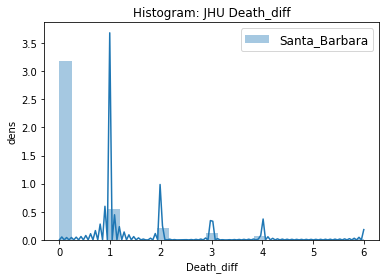

In [188]:

plt1 = sns.distplot(JHU_SantaBarbara_df['D_diff'], label='Santa_Barbara', bins=25)
#plt2 = sns.distplot(JHU_Ventura_df['Death'],  label='Ventura', bins=25)
#plt3 = sns.distplot(JHU_Sacramento_df['Death'],label='Sacramento', bins=25)

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Histogram: JHU Death_diff')
plt.xlabel('Death_diff')
plt.ylabel('dens')
#hist for delta 

(array([166.,  29.,   0.,  11.,   0.,   6.,   4.,   0.,   0.,   1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

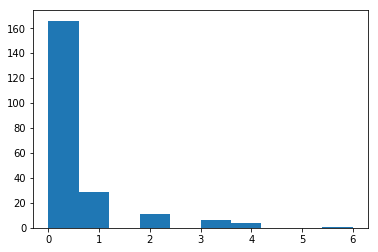

In [155]:
plt.hist(JHU_SantaBarbara_df['D_diff'])
#look for jumps in death to address outliers

C:\Users\dheym\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

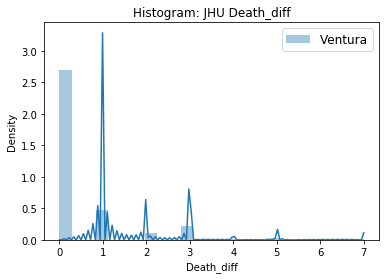

In [156]:
#plt1 = sns.distplot(JHU_SantaBarbara_df['Death'],   label='Santa_Barbara', bins=25)
plt2 = sns.distplot(JHU_Ventura_df['D_diff'],  label='Ventura', bins=25)
#plt3 = sns.distplot(JHU_Sacramento_df['Death'],   label='Sacramento', bins=25)

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Histogram: JHU Death_diff')
plt.xlabel('Death_diff')
plt.ylabel('Density')

(array([164.,  29.,   7.,   0.,  13.,   1.,   0.,   2.,   0.,   1.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

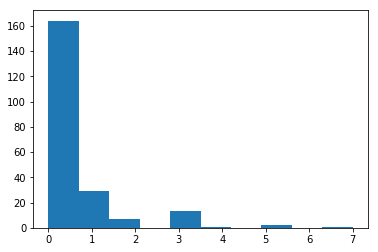

In [34]:
plt.hist(JHU_Ventura_df['D_diff'])

Text(0,0.5,'Count')

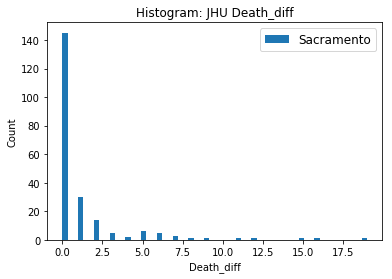

In [35]:
#plt1 = sns.distplot(JHU_SantaBarbara_df['Death'], label='Santa_Barbara', bins='auto')
#plt2 = sns.distplot(JHU_Ventura_df['Death'],  label='Ventura', bins='auto')
plt3 = plt.hist(JHU_Sacramento_df['D_diff'],  label='Sacramento', bins='auto')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Histogram: JHU Death_diff')
plt.xlabel('Death_diff')
plt.ylabel('Count')


Text(0,0.5,'Count')

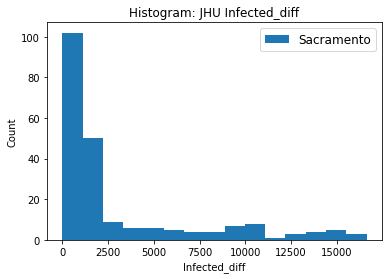

In [36]:
#plt1 = plt.hist(JHU_SantaBarbara_df['I_diff'], label='Santa_Barbara', bins='auto')
#plt2 = plt.hist(JHU_Ventura_df['Infected'],   label='Ventura', bins='auto')
plt3 = plt.hist(JHU_Sacramento_df['Infected'],  label='Sacramento', bins='auto')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Histogram: JHU Infected_diff')
plt.xlabel('Infected_diff')
plt.ylabel('Count')

(array([145.,   0.,   0.,  30.,   0.,   0.,  14.,   0.,   0.,   5.,   0.,
          0.,   2.,   0.,   0.,   6.,   0.,   0.,   5.,   0.,   0.,   3.,
          0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.]),
 array([ 0.        ,  0.32758621,  0.65517241,  0.98275862,  1.31034483,
         1.63793103,  1.96551724,  2.29310345,  2.62068966,  2.94827586,
         3.27586207,  3.60344828,  3.93103448,  4.25862069,  4.5862069 ,
         4.9137931 ,  5.24137931,  5.56896552,  5.89655172,  6.22413793,
         6.55172414,  6.87931034,  7.20689655,  7.53448276,  7.86206897,
         8.18965517,  8.51724138,  8.84482759,  9.17241379,  9.5       ,
         9.82758621, 10.15517241, 10.48275862, 10.81034483, 11.13793103,
        11.46551724, 11.79310345, 12.12068966, 12.44827586, 12.77586207,
        13.1034482

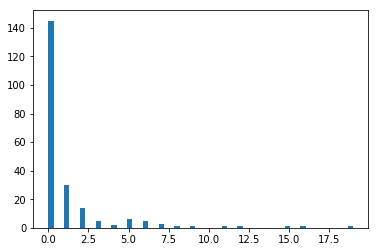

In [37]:
plt.hist(JHU_Sacramento_df['D_diff'], bins = 'auto')

Text(0,0.5,'Count')

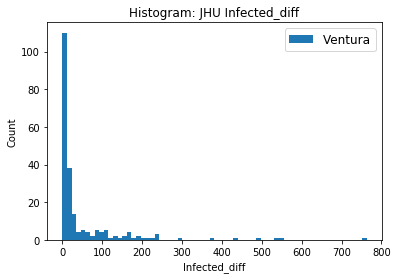

In [38]:
#plt1 = plt.hist(JHU_SantaBarbara_df['Infected'], label='Santa_Barbara', bins='auto')
plt2 = plt.hist(JHU_Ventura_df['I_diff'],   label='Ventura', bins='auto')
#plt3 = plt.hist(JHU_Sacramento_df['Infected'],  label='Sacramento', bins='auto')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Histogram: JHU Infected_diff')
plt.xlabel('Infected_diff')
plt.ylabel('Count')

Text(0,0.5,'Count')

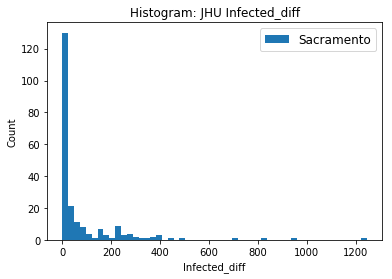

In [39]:
#plt1 = plt.hist(JHU_SantaBarbara_df['Infected'], label='Santa_Barbara', bins='auto')
#plt2 = plt.hist(JHU_Ventura_df['Infected'],   label='Ventura', bins='auto')
plt3 = plt.hist(JHU_Sacramento_df['I_diff'],  label='Sacramento', bins='auto')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Histogram: JHU Infected_diff')
plt.xlabel('Infected_diff')
plt.ylabel('Count')

**EPA data**
Ventura_CA_42602_simple, 
Ventura_CA_44201_simple, 
Ventura_CA_81102_simple, 
Ventura_CA_88101_simple,

Sacramento_CA_42602,(need to generate from API)
Sacramento_CA_44201,(need to generate from API)
Sacramento_CA_81102_simple,
Sacramento_CA_88101_simple,

SantaBarbara_CA_42101_simple,
SantaBarbara_CA_42401_simple,
SantaBarbara_CA_42602_simple,
SantaBarbara_CA_44201_simple,
SantaBarbara_CA_81102_simple,
SantaBarbara_CA_88101_simple 

In [189]:
#MORE DATA CLEANING- to get only one observation for each day (group by county and date and get mean)

Ventura_CA_44201_simple = pd.DataFrame(Ventura_CA_44201_simple.groupby(['county','date_local']).mean().mean_Ozone_ppm)
Ventura_CA_44201_simple = pd.DataFrame(Ventura_CA_44201_simple.reset_index())

Ventura_CA_42602_simplei  = Ventura_CA_42602_simple.copy()
Ventura_CA_42602_simplei = pd.DataFrame(Ventura_CA_42602_simplei.groupby(['county','date_local']).mean().mean_NO2_ppb)
Ventura_CA_42602_simplei.reset_index()
Ventura_CA_42602_simpleq  = Ventura_CA_42602_simple.copy()
Ventura_CA_42602_simpleq = pd.DataFrame(Ventura_CA_42602_simpleq.groupby(['county','date_local']).mean().aqi)
Ventura_CA_42602_simpleq.reset_index()
Ventura_CA_42602_simpleb = pd.merge(Ventura_CA_42602_simplei, Ventura_CA_42602_simpleq, on=['county','date_local'])
Ventura_CA_42602_simpleb = pd.DataFrame(Ventura_CA_42602_simpleb.reset_index())
Ventura_CA_42602_simple = pd.DataFrame(Ventura_CA_42602_simpleb)

Ventura_CA_81102_simple = pd.DataFrame(Ventura_CA_81102_simple.groupby(['county','date_local']).mean()['mean_PM10_µg_m3_25C'])
Ventura_CA_81102_simple = pd.DataFrame(Ventura_CA_81102_simple.reset_index())

Ventura_CA_88101_simple = pd.DataFrame(Ventura_CA_88101_simple.groupby(['county','date_local']).mean()['mean_PM2_5_µg_m3_LC'])
Ventura_CA_88101_simple = pd.DataFrame(Ventura_CA_88101_simple.reset_index())

#_____________________________________________________________________________________

Sacramento_CA_44201_simple = pd.DataFrame(Sacramento_CA_44201_simple.groupby(['county','date_local']).mean().mean_Ozone_ppm)
Sacramento_CA_44201_simple = pd.DataFrame(Sacramento_CA_44201_simple.reset_index())

Sacramento_CA_42602_simplei  = Sacramento_CA_42602_simple.copy()
Sacramento_CA_42602_simplei = pd.DataFrame(Sacramento_CA_42602_simplei.groupby(['county','date_local']).mean().mean_NO2_ppb)
Sacramento_CA_42602_simplei.reset_index()
Sacramento_CA_42602_simpleq  = Sacramento_CA_42602_simple.copy()
Sacramento_CA_42602_simpleq = pd.DataFrame(Sacramento_CA_42602_simpleq.groupby(['county','date_local']).mean().aqi)
Sacramento_CA_42602_simpleq.reset_index()
Sacramento_CA_42602_simpleb = pd.merge(Sacramento_CA_42602_simplei, Sacramento_CA_42602_simpleq, on=['county','date_local'])
Sacramento_CA_42602_simpleb = pd.DataFrame(Sacramento_CA_42602_simpleb.reset_index())
Sacramento_CA_42602_simple = pd.DataFrame(Sacramento_CA_42602_simpleb)

Sacramento_CA_81102_simple = pd.DataFrame(Sacramento_CA_81102_simple.groupby(['county','date_local']).mean()['mean_PM10_µg_m3_25C'])
Sacramento_CA_81102_simple = pd.DataFrame(Sacramento_CA_81102_simple.reset_index())

Sacramento_CA_88101_simple = pd.DataFrame(Sacramento_CA_88101_simple.groupby(['county','date_local']).mean()['mean_PM2_5_µg_m3_LC'])
Sacramento_CA_88101_simple = pd.DataFrame(Sacramento_CA_88101_simple.reset_index())


#_____________________________________________________________________________________

SantaBarbara_CA_44201_simple = pd.DataFrame(SantaBarbara_CA_44201_simple.groupby(['county','date_local']).mean().mean_Ozone_ppm)
SantaBarbara_CA_44201_simple = pd.DataFrame(SantaBarbara_CA_44201_simple.reset_index())

SantaBarbara_CA_42602_simplei  = SantaBarbara_CA_42602_simple.copy()
SantaBarbara_CA_42602_simplei = pd.DataFrame(SantaBarbara_CA_42602_simplei.groupby(['county','date_local']).mean().mean_NO2_ppb)
SantaBarbara_CA_42602_simplei.reset_index()
SantaBarbara_CA_42602_simpleq  = SantaBarbara_CA_42602_simple.copy()
SantaBarbara_CA_42602_simpleq = pd.DataFrame(SantaBarbara_CA_42602_simpleq.groupby(['county','date_local']).mean().aqi)
SantaBarbara_CA_42602_simpleq.reset_index()
SantaBarbara_CA_42602_simpleb = pd.merge(SantaBarbara_CA_42602_simplei, SantaBarbara_CA_42602_simpleq, on=['county','date_local'])
SantaBarbara_CA_42602_simpleb = pd.DataFrame(SantaBarbara_CA_42602_simpleb.reset_index())
SantaBarbara_CA_42602_simple = pd.DataFrame(SantaBarbara_CA_42602_simpleb)

SantaBarbara_CA_81102_simple = pd.DataFrame(SantaBarbara_CA_81102_simple.groupby(['county','date_local']).mean()['mean_PM10_µg_m3_25C'])
SantaBarbara_CA_81102_simple = pd.DataFrame(SantaBarbara_CA_81102_simple.reset_index())

SantaBarbara_CA_88101_simple = pd.DataFrame(SantaBarbara_CA_88101_simple.groupby(['county','date_local']).mean()['mean_PM2_5_µg_m3_LC'])
SantaBarbara_CA_88101_simple = pd.DataFrame(SantaBarbara_CA_88101_simple.reset_index())

SantaBarbara_CA_42101_simple = pd.DataFrame(SantaBarbara_CA_42101_simple.groupby(['county','date_local']).mean()['mean_CO_ppm'])
SantaBarbara_CA_42101_simple = pd.DataFrame(SantaBarbara_CA_42101_simple.reset_index())

SantaBarbara_CA_42401_simple = pd.DataFrame(SantaBarbara_CA_42401_simple.groupby(['county','date_local']).mean()['mean_SO2_ppb'])
SantaBarbara_CA_42401_simple = pd.DataFrame(SantaBarbara_CA_42401_simple.reset_index())

In [190]:

#OUTLIER DETECTION AND CLEANING
def clean_outliers(epa_df):
    epa_df.dropna()
    epa_col = epa_df[epa_df.columns[2]]
    oneptfiveIQR = 1.5*(epa_col.quantile(.75)- epa_col.quantile(.25))
    upper_cut = epa_col.quantile(.75)+ oneptfiveIQR
    lower_cut = epa_col.quantile(.25)- oneptfiveIQR
    outliers = []
    outliersind = []
    count = 0
    for g in epa_col:
        if g>upper_cut or g<lower_cut:
            print("bad: ", g, count)
            outliers.append(g)
            outliersind.append(count)
        count += 1    
    for y in outliers:
        print(y)
    #df[~df.index.isin(list_to_exclude)]    
    epa_df = epa_df[~epa_df.index.isin(outliersind)]
    print("start date: ", epa_df.date_local.min(), ": end date: ", epa_df.date_local.max(), " unique number of days: ", epa_df.date_local.nunique(), "n rows: ", len(epa_df))
    return epa_df


In [191]:
#dont run this more than once....
epa_dfs = [Ventura_CA_42602_simple, 
Ventura_CA_44201_simple, 
Ventura_CA_81102_simple, 
Ventura_CA_88101_simple,         

Sacramento_CA_81102_simple,
Sacramento_CA_88101_simple,
Sacramento_CA_42602_simple,
Sacramento_CA_44201_simple,
           
SantaBarbara_CA_42101_simple,
SantaBarbara_CA_42401_simple,
SantaBarbara_CA_42602_simple,
SantaBarbara_CA_44201_simple,
SantaBarbara_CA_81102_simple,
SantaBarbara_CA_88101_simple
          ]

#OUTLIER DETECTION AND CLEANING
Ventura_CA_42602_simple = clean_outliers(Ventura_CA_42602_simple)
Ventura_CA_44201_simple = clean_outliers(Ventura_CA_44201_simple)
Ventura_CA_81102_simple = clean_outliers(Ventura_CA_81102_simple)
Ventura_CA_88101_simple = clean_outliers(Ventura_CA_88101_simple)     

Sacramento_CA_81102_simple = clean_outliers(Sacramento_CA_81102_simple)
Sacramento_CA_88101_simple = clean_outliers(Sacramento_CA_88101_simple)
Sacramento_CA_42602_simple = clean_outliers(Sacramento_CA_42602_simple)
Sacramento_CA_44201_simple = clean_outliers(Sacramento_CA_44201_simple)
           
SantaBarbara_CA_42101_simple = clean_outliers(SantaBarbara_CA_42101_simple)
SantaBarbara_CA_42401_simple = clean_outliers(SantaBarbara_CA_42401_simple)
SantaBarbara_CA_42602_simple = clean_outliers(SantaBarbara_CA_42602_simple)
SantaBarbara_CA_44201_simple = clean_outliers(SantaBarbara_CA_44201_simple)
SantaBarbara_CA_81102_simple = clean_outliers(SantaBarbara_CA_81102_simple)
SantaBarbara_CA_88101_simple = clean_outliers(SantaBarbara_CA_88101_simple)

bad:  15.205314000000001 13
bad:  12.347826000000001 19
bad:  13.949275 36
bad:  13.4130435 37
15.205314000000001
12.347826000000001
13.949275
13.4130435
start date:  2020-01-01 : end date:  2020-06-30  unique number of days:  148 n rows:  148
bad:  0.04562210000000001 96
bad:  0.0498464 97
bad:  0.04444965 98
bad:  0.04527664999999999 131
0.04562210000000001
0.0498464
0.04444965
0.04527664999999999
start date:  2020-01-01 : end date:  2020-06-30  unique number of days:  148 n rows:  148
start date:  2020-01-01 : end date:  2020-07-08  unique number of days:  188 n rows:  188
bad:  17.62111113333333 186
17.62111113333333
start date:  2020-01-01 : end date:  2020-07-08  unique number of days:  189 n rows:  189
bad:  38.4375 37
bad:  37.416666500000005 42
bad:  39.25 49
38.4375
37.416666500000005
39.25
start date:  2020-01-01 : end date:  2020-06-26  unique number of days:  154 n rows:  154
bad:  23.699999999999996 0
bad:  18.688888888888886 2
bad:  20.49732617647058 3
bad:  22.809718647

# Covariate EPA Pollutants and Mobility Histograms

**Ventura histograms**

C:\Users\dheym\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\dheym\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\dheym\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

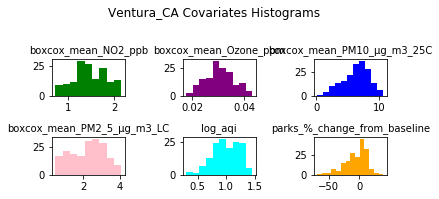

In [192]:
plt.suptitle('Ventura_CA Covariates Histograms')
plt.subplot(331)
#plt1 = plt.hist(Ventura_CA_42602_simple["mean_NO2_ppb"],  color = "purple", label='Ventura_mean_NO2_ppb', bins=25)
#skewed so use log or ln+1 for symmetric
#Ventura_CA_42602_simple
#Ventura_CA_42602_simple['log_mean_NO2_ppb'] = np.log10(Ventura_CA_42602_simple['mean_NO2_ppb']) 
Ventura_CA_42602_simple['boxcox_mean_NO2_ppb'] = sp.special.boxcox1p(Ventura_CA_42602_simple['mean_NO2_ppb'].values, -.14) 
plt2 = plt.hist(Ventura_CA_42602_simple["boxcox_mean_NO2_ppb"], color = "green", label='Ventura_log_mean_NO2_ppb', bins='auto')
plt.title("boxcox_mean_NO2_ppb", size = 10)

plt.subplot(332)
Ventura_CA_44201_simple['boxcox_mean_Ozone_ppm'] = sp.special.boxcox1p(Ventura_CA_44201_simple['mean_Ozone_ppm'].values, 3) 
plt2 = plt.hist(Ventura_CA_44201_simple["boxcox_mean_Ozone_ppm"], color = "purple", label='Ventura_mean_Ozone_ppm"', bins='auto')
plt.title("boxcox_mean_Ozone_ppm", size = 10)

plt.subplot(333)
Ventura_CA_81102_simple['boxcox_mean_PM10_µg_m3_25C'] = sp.special.boxcox1p(Ventura_CA_81102_simple['mean_PM10_µg_m3_25C'].values, .5) 
plt2 = plt.hist(Ventura_CA_81102_simple["boxcox_mean_PM10_µg_m3_25C"], color = "blue", label='Ventura_boxcox_mean_PM10_µg_m3_25C', bins='auto')
plt.title("boxcox_mean_PM10_µg_m3_25C", size = 10)

plt.subplot(334)
Ventura_CA_88101_simple['boxcox_mean_PM2_5_µg_m3_LC'] = sp.special.boxcox1p(Ventura_CA_88101_simple['mean_PM2_5_µg_m3_LC'].values, .3) 
plt2 = plt.hist(Ventura_CA_88101_simple["boxcox_mean_PM2_5_µg_m3_LC"], color = "pink", label='Ventura_boxcox_mean_PM2_5_µg_m3_LC', bins='auto')
plt.title("boxcox_mean_PM2_5_µg_m3_LC", size = 10)

plt.subplot(335)
Ventura_CA_42602_simple['log_aqi'] = np.log10(Ventura_CA_42602_simple['aqi']) 
plt1 = plt.hist(Ventura_CA_42602_simple["log_aqi"], color = "cyan", label='Ventura_log_aqi', bins='auto')
plt.title("log_aqi", size = 10)

plt.subplot(336)
#Ventura_mobility_simple['boxcox_parks_percent_change_from_baseline'] = np.log10(Ventura_mobility_simple['parks_percent_change_from_baseline']) 
plt1 = plt.hist(Ventura_mobility_simple["parks_percent_change_from_baseline"], color = "orange", label='Ventura_parks_percent_change_from_baseline', bins='auto')
plt.title("parks_%_change_from_baseline", size = 10)
#try boxcox, sqrt xform

#plt.figure(figsize=(10,3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=.8, wspace=.8, hspace=1.1)

**Santa Barbara Histograms**

In [193]:
#impromptu data cleaning as we have negative values for mean_NO2_ppb
SantaBarbara_CA_42602_simple.mean_NO2_ppb.min()
SantaBarbara_CA_42602_simple['mean_NO2_ppb']= SantaBarbara_CA_42602_simple.mean_NO2_ppb.apply(lambda x: max(0,x))
SantaBarbara_CA_42602_simple.mean_NO2_ppb.min()
SantaBarbara_CA_88101_simple.dropna()

,county,date_local,mean_PM2_5_µg_m3_LC
0,Santa Barbara,2020-01-01,6.810833
1,Santa Barbara,2020-01-02,4.159583
2,Santa Barbara,2020-01-03,4.207917
3,Santa Barbara,2020-01-04,5.911667
4,Santa Barbara,2020-01-05,2.459094
5,Santa Barbara,2020-01-06,2.085308
6,Santa Barbara,2020-01-07,2.830018
7,Santa Barbara,2020-01-08,1.361250
8,Santa Barbara,2020-01-09,0.949583
9,Santa Barbara,2020-01-10,3.056667


C:\Users\dheym\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dheym\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dheym\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

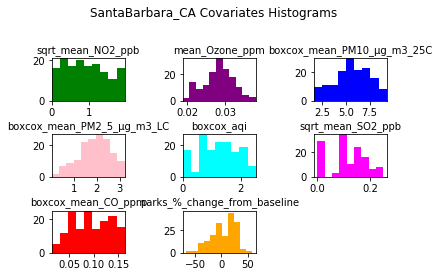

In [196]:
plt.suptitle('SantaBarbara_CA Covariates Histograms')
plt.subplot(331)
#SantaBarbara_CA_42602_simple['boxcox_mean_NO2_ppb'] = sp.special.boxcox1p(SantaBarbara_CA_42602_simple['mean_NO2_ppb'].values, -2.5) 
SantaBarbara_CA_42602_simple['sqrt_mean_NO2_ppb'] = np.sqrt(SantaBarbara_CA_42602_simple['mean_NO2_ppb'].values)
plt2 = plt.hist(SantaBarbara_CA_42602_simple["sqrt_mean_NO2_ppb"], color = "green", label='SantaBarbara_boxcox_mean_NO2_ppb', bins='auto')
plt.title("sqrt_mean_NO2_ppb", size = 10)
plt.autoscale(tight = True)
#SantaBarbara_CA_42602_simple.drop(columns=['boxcox_mean_NO2_ppb'])

plt.subplot(332)
plt2 = plt.hist(SantaBarbara_CA_44201_simple["mean_Ozone_ppm"], color = "purple", label='SantaBarbara_mean_Ozone_ppm"', bins='auto')
plt.title("mean_Ozone_ppm", size = 10)
plt.autoscale(tight = True)

plt.subplot(333)
SantaBarbara_CA_81102_simple['boxcox_mean_PM10_µg_m3_25C'] = sp.special.boxcox1p(SantaBarbara_CA_81102_simple['mean_PM10_µg_m3_25C'].values, .5) 
plt2 = plt.hist(SantaBarbara_CA_81102_simple["boxcox_mean_PM10_µg_m3_25C"], color = "blue", label='SantaBarbara_boxcox_mean_PM10_µg_m3_25C', bins='auto')
plt.title("boxcox_mean_PM10_µg_m3_25C", size = 10)
plt.autoscale(tight = True)

plt.subplot(334)
SantaBarbara_CA_88101_simple['boxcox_mean_PM2_5_µg_m3_LC'] = sp.special.boxcox1p(SantaBarbara_CA_88101_simple['mean_PM2_5_µg_m3_LC'].values, .18) 
plt2 = plt.hist(SantaBarbara_CA_88101_simple["boxcox_mean_PM2_5_µg_m3_LC"], color = "pink", label='SantaBarbara_boxcox_mean_PM2_5_µg_m3_LC', bins='auto')
plt.title("boxcox_mean_PM2_5_µg_m3_LC", size = 10)
plt.autoscale(tight = True)

plt.subplot(335)
SantaBarbara_CA_42602_simple['boxcox_aqi'] = sp.special.boxcox1p(SantaBarbara_CA_42602_simple['aqi'].values, 0) 
plt1 = plt.hist(SantaBarbara_CA_42602_simple["boxcox_aqi"], color = "cyan", label='SantaBarbara_boxcox_aqi', bins='auto')
plt.title("boxcox_aqi", size = 10)
plt.autoscale(tight = True)

plt.subplot(336)
#SantaBarbara_CA_42401_simple['boxcox_mean_SO2_ppb'] = sp.special.boxcox1p(SantaBarbara_CA_42401_simple['mean_SO2_ppb'].values, 5) 
SantaBarbara_CA_42401_simple['sqrt_mean_SO2_ppb'] = np.sqrt(SantaBarbara_CA_42401_simple['mean_SO2_ppb'].values) 
#SantaBarbara_CA_42401_simple['log_mean_SO2_ppb'] = np.log10(SantaBarbara_CA_42401_simple['mean_SO2_ppb'].values) 
plt1 = plt.hist(SantaBarbara_CA_42401_simple["sqrt_mean_SO2_ppb"], color = "magenta", label='SantaBarbara_boxcox_mean_SO2_ppb', bins='auto')
plt.title("sqrt_mean_SO2_ppb", size = 10)
plt.autoscale(enable = True, tight = True, axis = "y")

plt.subplot(337)
SantaBarbara_CA_42101_simple['boxcox_mean_CO_ppm'] = sp.special.boxcox1p(SantaBarbara_CA_42101_simple['mean_CO_ppm'].values, -3.5) 
plt1 = plt.hist(SantaBarbara_CA_42101_simple["boxcox_mean_CO_ppm"], color = "red", label='SantaBarbara_boxcox_mean_CO_ppm', bins='auto')
plt.title("boxcox_mean_CO_ppm", size = 10)
plt.autoscale(tight = True)
#truncate

plt.subplot(338)
plt1 = plt.hist(SantaBarbara_mobility_simple["parks_percent_change_from_baseline"], color = "orange", label='SantaBarbara_parks_percent_change_from_baseline', bins='auto')
plt.title("parks_%_change_from_baseline", size = 10)

#plt.figure(figsize=(10,3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=.8, wspace=.8, hspace=.8)

C:\Users\dheym\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


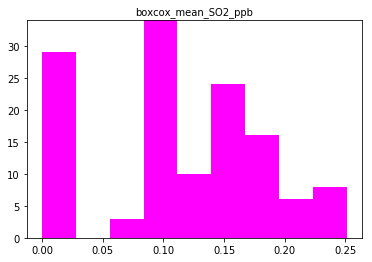

In [197]:
#SantaBarbara_CA_42401_simple['boxcox_mean_SO2_ppb'] = sp.special.boxcox1p(SantaBarbara_CA_42401_simple['mean_SO2_ppb'].values, -20) 
SantaBarbara_CA_42401_simple['sqrt_mean_SO2_ppb'] = np.sqrt(SantaBarbara_CA_42401_simple['mean_SO2_ppb'].values) 
#SantaBarbara_CA_42401_simple['log_mean_SO2_ppb'] = np.log10(SantaBarbara_CA_42401_simple['mean_SO2_ppb'].values) 
plt1 = plt.hist(SantaBarbara_CA_42401_simple["sqrt_mean_SO2_ppb"], color = "magenta", label='SantaBarbara_boxcox_mean_SO2_ppb', bins='auto')
plt.title("boxcox_mean_SO2_ppb", size = 10)
plt.autoscale(enable = True, tight = True, axis = "y")

C:\Users\dheym\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dheym\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\dheym\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

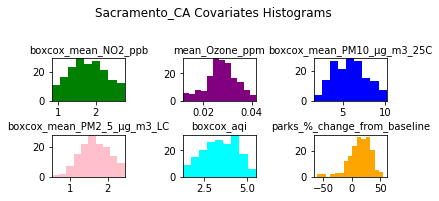

In [198]:
plt.suptitle('Sacramento_CA Covariates Histograms')
plt.subplot(331)
Sacramento_CA_42602_simple['boxcox_mean_NO2_ppb'] = sp.special.boxcox1p(Sacramento_CA_42602_simple['mean_NO2_ppb'].values, 0) 
plt2 = plt.hist(Sacramento_CA_42602_simple["boxcox_mean_NO2_ppb"], color = "green", label='Sacramento_boxcox_mean_NO2_ppb', bins='auto')
plt.title("boxcox_mean_NO2_ppb", size = 10)
plt.autoscale(tight = True)

plt.subplot(332)
plt2 = plt.hist(Sacramento_CA_44201_simple["mean_Ozone_ppm"], color = "purple", label='Sacramento_mean_Ozone_ppm"', bins='auto')
plt.title("mean_Ozone_ppm", size = 10)
plt.autoscale(tight = True)

plt.subplot(333)
Sacramento_CA_81102_simple['boxcox_mean_PM10_µg_m3_25C'] = sp.special.boxcox1p(Sacramento_CA_81102_simple['mean_PM10_µg_m3_25C'].values, .5) 
plt2 = plt.hist(Sacramento_CA_81102_simple["boxcox_mean_PM10_µg_m3_25C"], color = "blue", label='Sacramento_boxcox_mean_PM10_µg_m3_25C', bins='auto')
plt.title("boxcox_mean_PM10_µg_m3_25C", size = 10)
plt.autoscale(tight = True)

plt.subplot(334)
Sacramento_CA_88101_simple['boxcox_mean_PM2_5_µg_m3_LC'] = sp.special.boxcox1p(Sacramento_CA_88101_simple['mean_PM2_5_µg_m3_LC'].values, -.1)                                                                                 
plt2 = plt.hist(Sacramento_CA_88101_simple["boxcox_mean_PM2_5_µg_m3_LC"], color = "pink", label='Sacramento_boxcox_mean_PM2_5_µg_m3_LC', bins='auto')
plt.title("boxcox_mean_PM2_5_µg_m3_LC", size = 10)
plt.autoscale(tight = True)

plt.subplot(335)
Sacramento_CA_42602_simple['boxcox_aqi'] = sp.special.boxcox1p(Sacramento_CA_42602_simple['aqi'].values, .25) 
plt1 = plt.hist(Sacramento_CA_42602_simple["boxcox_aqi"], color = "cyan", label='Sacramento_boxcox_aqi', bins='auto')
plt.title("boxcox_aqi", size = 10)
plt.autoscale(tight = True)

plt.subplot(336)
plt1 = plt.hist(Sacramento_mobility_simple["parks_percent_change_from_baseline"], color = "orange", label='Sacramento_parks_percent_change_from_baseline', bins='auto')
plt.title("parks_%_change_from_baseline", size = 10)

#plt.figure(figsize=(10,3))
plt.subplots_adjust(left=None, bottom=None, right=None, top=.8, wspace=.8, hspace=.8)

**Santa Barbara Time Series Covariates plots**

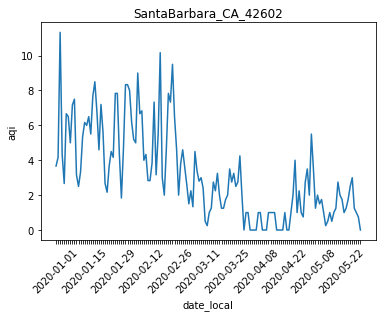

In [199]:
plot1 = sns.lineplot(data = SantaBarbara_CA_42602_simple, y= "aqi", x="date_local")
for ind, label in enumerate(plot1.get_xticklabels()):
    if ind % 14 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.title('SantaBarbara_CA_42602')
plt.show()

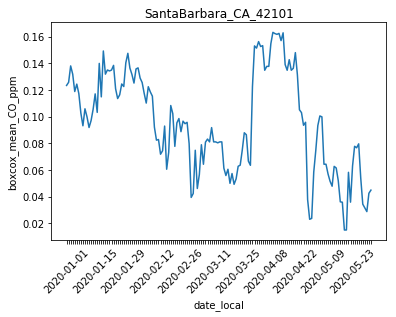

In [98]:
plot1 = sns.lineplot(data = SantaBarbara_CA_42101_simple, y= "boxcox_mean_CO_ppm", x="date_local")
for ind, label in enumerate(plot1.get_xticklabels()):
    if ind % 14 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.title('SantaBarbara_CA_42101')
plt.show()


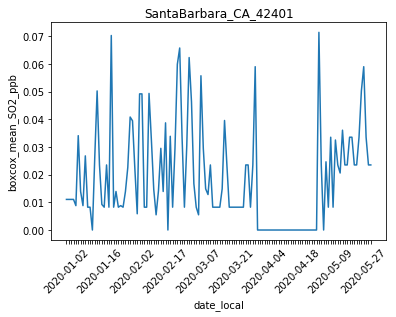

In [99]:
plot1 = sns.lineplot(data = SantaBarbara_CA_42401_simple, y= "boxcox_mean_SO2_ppb", x="date_local")
for ind, label in enumerate(plot1.get_xticklabels()):
    if ind % 14 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.title('SantaBarbara_CA_42401')
plt.show()


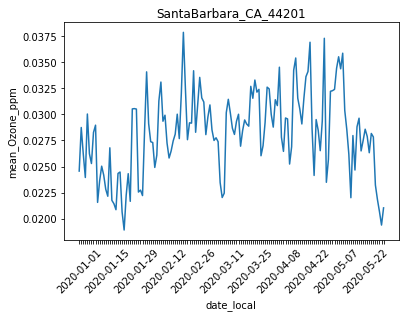

In [100]:
plot1 = sns.lineplot(data = SantaBarbara_CA_44201_simple, y= "mean_Ozone_ppm", x="date_local")
for ind, label in enumerate(plot1.get_xticklabels()):
    if ind % 14 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.title('SantaBarbara_CA_44201')
plt.show()


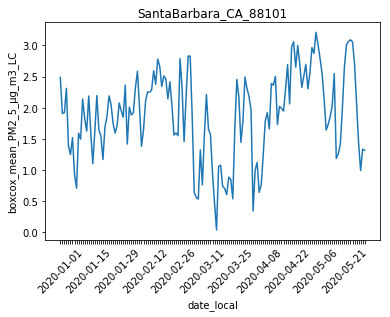

In [103]:
plot1 = sns.lineplot(data = SantaBarbara_CA_88101_simple, y= "boxcox_mean_PM2_5_µg_m3_LC", x="date_local")
for ind, label in enumerate(plot1.get_xticklabels()):
    if ind % 14 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.title('SantaBarbara_CA_88101')
plt.show()


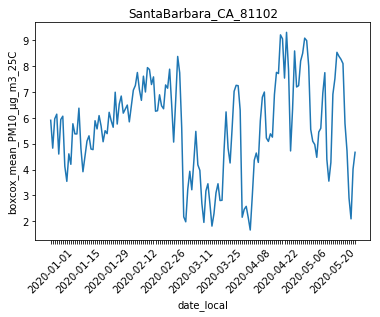

In [106]:
plot1 = sns.lineplot(data = SantaBarbara_CA_81102_simple, y= "boxcox_mean_PM10_µg_m3_25C", x="date_local")
for ind, label in enumerate(plot1.get_xticklabels()):
    if ind % 14 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.title('SantaBarbara_CA_81102')
plt.show()


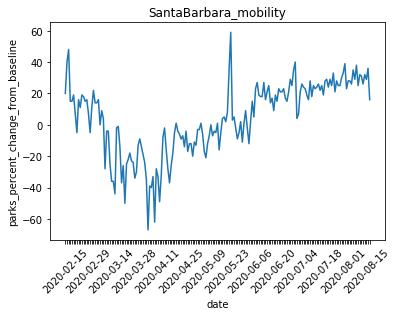

In [107]:
plot1 = sns.lineplot(data = SantaBarbara_mobility_simple, y= "parks_percent_change_from_baseline", x="date")
for ind, label in enumerate(plot1.get_xticklabels()):
    if ind % 14 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.title('SantaBarbara_mobility')
plt.show()


**Ventura Time Series Covariate plots**

In [108]:
plot1 = sns.lineplot(data = Ventura_CA_42602_simple, y= "log_mean_NO2_ppb", x="date_local")
for ind, label in enumerate(plot1.get_xticklabels()):
    if ind % 14 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.title('Ventura_CA_42602')
plt.show()


ValueError: Could not interpret input 'log_mean_NO2_ppb'

C:\Users\dheym\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


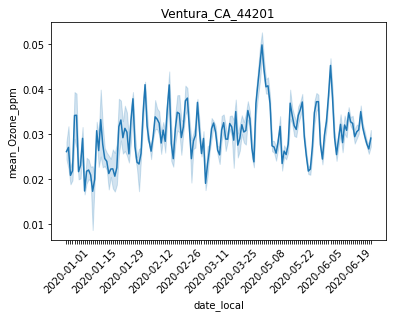

In [59]:
plot1 = sns.lineplot(data = Ventura_CA_44201_simple, y= "mean_Ozone_ppm", x="date_local")
for ind, label in enumerate(plot1.get_xticklabels()):
    if ind % 14 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.title('Ventura_CA_44201')
plt.show()

C:\Users\dheym\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


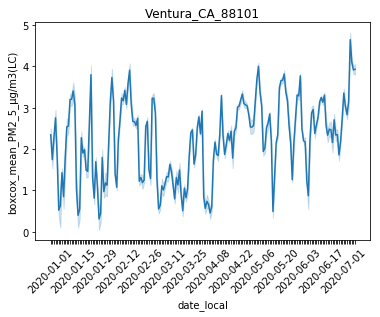

In [60]:
plot1 = sns.lineplot(data = Ventura_CA_88101_simple, y= "boxcox_mean_PM2_5_µg/m3(LC)", x="date_local")
for ind, label in enumerate(plot1.get_xticklabels()):
    if ind % 14 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.title('Ventura_CA_88101')
plt.show()

In [110]:
SantaBarbara_CA_88101_simple.head(1)

,county,date_local,mean_PM2_5_µg_m3_LC,boxcox_mean_PM2_5_µg_m3_LC
0,Santa Barbara,2020-01-01,6.810833,2.487351


# Dataset creation

In [207]:
SantaBarbara_merged = pd.merge(SantaBarbara_CA_42602_simple, SantaBarbara_CA_44201_simple, how = 'outer', on=['county','date_local'])
SantaBarbara_merged = pd.merge(SantaBarbara_merged, SantaBarbara_CA_81102_simple, how = 'outer', on=['county','date_local'])
SantaBarbara_merged = pd.merge(SantaBarbara_merged, SantaBarbara_CA_88101_simple, how = 'outer', on=['county','date_local'])
SantaBarbara_merged = pd.merge(SantaBarbara_merged, SantaBarbara_CA_42401_simple, how = 'outer', on=['county','date_local'])
SantaBarbara_merged = pd.merge(SantaBarbara_merged, SantaBarbara_CA_42101_simple, how = 'outer', on=['county','date_local'])
SantaBarbara_mobility_simple =pd.DataFrame(SantaBarbara_mobility_simple).rename(columns={'date': 'date_local'})
SantaBarbara_merged = pd.merge(SantaBarbara_merged, SantaBarbara_mobility_simple, how = 'outer', on=['date_local'])
SantaBarbara_merged = SantaBarbara_merged.rename(columns={'date_local': 'Date'})
SantaBarbara_merged['Date'] =  pd.to_datetime(SantaBarbara_merged['Date'])
JHU_SantaBarbara_df['Date'] = pd.to_datetime(JHU_SantaBarbara_df['Date'])
SantaBarbara_merged = pd.merge(SantaBarbara_merged, JHU_SantaBarbara_df, how = 'outer', on=['Date'])


In [209]:
SantaBarbara_merged.to_csv(r'C:\Users\dheym\OneDrive\Documents\GitHub\csci708\src\SantaBarbara_merged.csv', index = None, header=True)

Text(0.5,1,'Santa Barbara Correlation Heatmap')

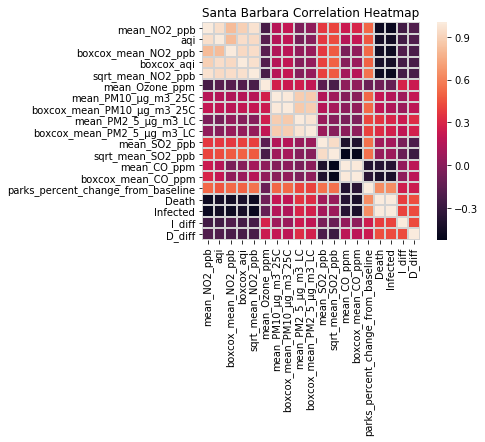

In [224]:
corr = SantaBarbara_merged.corr()
sns.heatmap(corr,
            square=True, linecolor="lightgray", linewidths=1)
plt.title("Santa Barbara Correlation Heatmap")
#multicollinearity problems: keep aqi get rid of no2; keep PM2.5 get rid of pm10

In [216]:
Sacramento_merged = pd.merge(Sacramento_CA_42602_simple, Sacramento_CA_44201_simple, how = 'outer', on=['county','date_local'])
Sacramento_merged = pd.merge(Sacramento_merged, Sacramento_CA_81102_simple, how = 'outer', on=['county','date_local'])
Sacramento_merged = pd.merge(Sacramento_merged, Sacramento_CA_88101_simple, how = 'outer', on=['county','date_local'])
Sacramento_mobility_simple =pd.DataFrame(Sacramento_mobility_simple).rename(columns={'date': 'date_local'})
Sacramento_merged = pd.merge(Sacramento_merged, Sacramento_mobility_simple, how = 'outer', on=['date_local'])
Sacramento_merged = Sacramento_merged.rename(columns={'date_local': 'Date'})
Sacramento_merged['Date'] =  pd.to_datetime(Sacramento_merged['Date'])
JHU_Sacramento_df['Date'] = pd.to_datetime(JHU_Sacramento_df['Date'])
Sacramento_merged = pd.merge(Sacramento_merged, JHU_Sacramento_df, how = 'outer', on=['Date'])




In [219]:
Sacramento_merged.to_csv(r'C:\Users\dheym\OneDrive\Documents\GitHub\csci708\src\Sacramento_merged.csv', index = None, header=True)

Text(0.5,1,'Sacramento Correlation Heatmap')

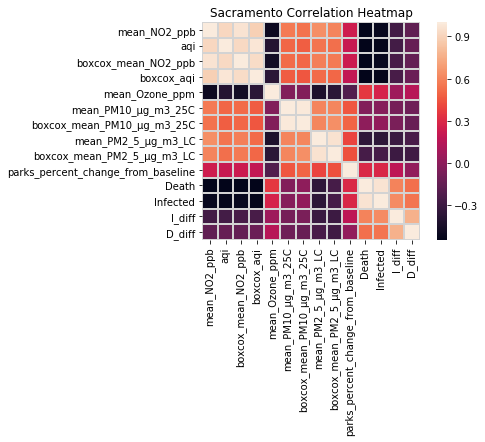

In [225]:
corr = Sacramento_merged.corr()
sns.heatmap(corr,
            square=True, linecolor="lightgray", linewidths=1)
plt.title("Sacramento Correlation Heatmap")
#multicollinearity problems: keep aqi get rid of no2; keep PM2.5 get rid of pm10

In [220]:
Ventura_merged = pd.merge(Ventura_CA_42602_simple, Ventura_CA_44201_simple, how = 'outer', on=['county','date_local'])
Ventura_merged = pd.merge(Ventura_merged, Ventura_CA_81102_simple, how = 'outer', on=['county','date_local'])
Ventura_merged = pd.merge(Ventura_merged, Ventura_CA_88101_simple, how = 'outer', on=['county','date_local'])
Ventura_mobility_simple =pd.DataFrame(Ventura_mobility_simple).rename(columns={'date': 'date_local'})
Ventura_merged = pd.merge(Ventura_merged, Ventura_mobility_simple, how = 'outer', on=['date_local'])
Ventura_merged = Ventura_merged.rename(columns={'date_local': 'Date'})
Ventura_merged['Date'] =  pd.to_datetime(Ventura_merged['Date'])
JHU_Ventura_df['Date'] = pd.to_datetime(JHU_Ventura_df['Date'])
Ventura_merged = pd.merge(Ventura_merged, JHU_Ventura_df, how = 'outer', on=['Date'])



In [221]:
Ventura_merged.to_csv(r'C:\Users\dheym\OneDrive\Documents\GitHub\csci708\src\Ventura_merged.csv', index = None, header=True)

Text(0.5,1,'Ventura Correlation Heatmap')

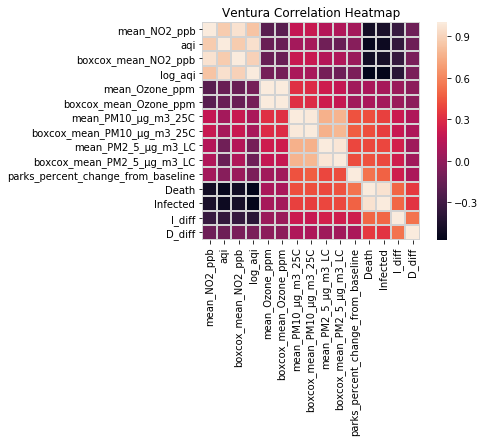

In [226]:
corr = Ventura_merged.corr()
sns.heatmap(corr,
            square=True, linecolor="lightgray", linewidths=1)
plt.title("Ventura Correlation Heatmap")
#multicollinearity problems: keep aqi get rid of no2; keep PM2.5 get rid of pm10

# Regression Model Assumptions

In [23]:
#normality of residuals, hist, corr, colinearity, check to see if transform is needed
#check to see if pollution have seasonal/trend aspect
#time series - potentially can just subtract mean- but this can create negative counts, 


#try both:
#model deaths and model infections
#policies data 

#AR model with auxillary vars - count as response
#ARIMA

#R package tscount

#histogram for each covariate
#corr
#AR2 (2 lags)

#mgcv package R


#########
#Questions: transorming the problematic covariate; should I use a [0,1] scaler for mobility

#lead measurements research to see how to record observation